# Caminhos da IA na saúde: ferramenta para o diagnóstico de Parkinson

> Por: Vitor Negromonte, Rafael Bastos, Gabriel Matias

#### Treinando modelos convolucionais e vision transformer como ferramenta de auxílio ao diagnóstico de Parkinson.

Dataset utilizado: [```kmader/parkinsons-drawings```](https://www.kaggle.com/datasets/kmader/parkinsons-drawings)

## Setup

In [1]:
%%capture
!pip install kaggle
!pip install optuna
!pip install zeus-ml

!kaggle datasets download -d kmader/parkinsons-drawings

In [2]:
import os
import glob
import random
import time

import zipfile
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate, tabulate_formats

import cv2
import ntpath
import optuna
from optuna import trial

import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F, torch.nn.init as init
import torchvision, torchvision.transforms as T
from torch.optim import lr_scheduler, Adam
from torchvision import models, transforms
from torchvision.transforms import v2 as transformsV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SequentialSampler

from zeus.monitor import ZeusMonitor
from zeus.optimizer.power_limit import GlobalPowerLimitOptimizer

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.utils import shuffle

# Verificando se a GPU está ativa
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
%%capture
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [4]:
file_path = '/content/parkinsons-drawings.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

## Funções e classes


### Classe e funções de manipulação do dataset

In [5]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor and adjust dimensions

        return image, label

# Function to get base directory name from the path
def baseDir(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Function to load images and labels
def loadData(X_data, y_data, path):
    files = glob.glob(f"{path}/*.png")
    dirname = baseDir(path)

    for img in files:
        image = cv2.imread(img)
        X_data.append(image)
        if dirname == 'healthy':
            y_data.append(0)
        else:
            y_data.append(1)
    return X_data, y_data

# Function to resize images with padding
def resize_with_padding(data, exp_shape):
    for i in range(len(data)):
        img = data[i]
        img_shape = [img.shape[1], img.shape[0]]
        if img_shape != exp_shape:
            ratio = max(exp_shape)/max(img_shape)
            new_size = tuple([int(x*ratio) for x in img_shape])
            img = cv2.resize(img, new_size)
            delta_w = exp_shape[0] - new_size[0]
            delta_h = exp_shape[1] - new_size[1]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255,255,255))
            data[i] = img
    return data

# Function to augment the dataset
def augment(data, label):
    augmented_data = []
    augmented_label = []

    for n in range(len(data)):
        img = data[n]
        augmented_data.extend([
            img,
            cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
            cv2.rotate(img, cv2.ROTATE_180),
            cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE),
            cv2.flip(img, 1),
            cv2.rotate(cv2.flip(img, 1), cv2.ROTATE_90_CLOCKWISE),
            cv2.rotate(cv2.flip(img, 1), cv2.ROTATE_180),
            cv2.rotate(cv2.flip(img, 1), cv2.ROTATE_90_COUNTERCLOCKWISE),
        ])
        augmented_label.extend([label[n]] * 8)

    return augmented_data, augmented_label


### Funções de plot

In [6]:
def countClasses(data, classes):
  cnt = []
  for i in range(len(classes)):
    cnt.append(data.count(classes[i]))

  return cnt

# Plotar amostra dos dados
def plotSamples(data, title):
  x = 0; y = 0
  samp = random.sample(data, 5)
  fig1, axs1 = plt.subplots(nrows=1, ncols=5)
  fig1.suptitle(title, y=0.65)
  for img in samp:
    axs1[x].imshow(img)
    axs1[x].axis('off')
    x = x+1
  samp = random.sample(data, 5)
  fig2, axs2 = plt.subplots(nrows=1, ncols=5)
  for img in samp:
    axs2[y].imshow(img)
    axs2[y].axis('off')
    y = y+1
  plt.show()

# Plotar avaliação dos modelos
def plotMisclassed(X_test, y_test, model):
  errors = []

  pred_y = np.argmax(model.predict(X_test), axis=-1)
  for i in range(pred_y.shape[0]):
    errors.append(int(pred_y[i] != y_test[i]))

  for i in range(len(errors)):
    if errors[i] == 1:
      label = 'Parkinson' if pred_y[i] == 1 else 'Healthy'
      plt.imshow(X_pd_test[i])
      plt.axis('off')
      plt.title(f'Wrong prediction: {label}')
      plt.show()

In [7]:
# Visualização dos kernels de convolução
def visualize_conv_kernels(model):
    conv_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv2d)]

    for i, conv in enumerate(conv_layers):
        kernels = conv.weight.data.cpu()
        num_kernels = kernels.shape[0]

        plt.figure(figsize=(10, 10))
        for j in range(num_kernels):
            plt.subplot(8, 8, j + 1)
            plt.imshow(kernels[j][0], cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Convolutional Layer {i+1}')
        plt.show()

### Função de treinamento

In [8]:
def training(model, model_name, epochs, train_loader, val_loader, device):

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.03)

    # Initialize Zeus for energy optimization
    monitor = ZeusMonitor(gpu_indices=[0])
    plo = GlobalPowerLimitOptimizer(monitor)

    # Initialize lists to store loss and accuracy
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        plo.on_epoch_begin()  # Start monitoring the energy usage for this epoch

        for inputs, labels in train_loader:
            plo.on_step_begin()  # Monitor the start of the step

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

            plo.on_step_end()  # End of step monitoring

        scheduler.step()

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = loss_function(val_outputs, val_labels)

                val_running_loss += val_loss.item() * val_inputs.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_total += val_labels.size(0)

        val_epoch_loss = val_running_loss / val_total
        val_epoch_acc = val_running_corrects.double() / val_total
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        plo.on_epoch_end()  # End monitoring for this epoch

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    end_time = time.time()
    exec_time = end_time - start_time

    # Plot accuracy
    plt.figure()
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.ylim([0, 1])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure()
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return exec_time

### Função de avaliação

In [9]:
def evaluate_model(model_name, model, test_data_tensor, test_labels_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(test_data_tensor)
        _, predicted = torch.max(outputs.data, 1)
        total = test_labels_tensor.size(0)
        correct = (predicted == test_labels_tensor).sum().item()
        accuracy = correct / total

        # Print the classification report and confusion matrix
        print('Classification Report')
        class_report = classification_report(test_labels_tensor.cpu(), predicted.cpu())
        print(class_report)

        print('\nConfusion Matrix')
        conf_matrix = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        print(conf_matrix)

        # Print true positive rate for each class
        TPR = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        print('\nTrue Positive Rate')
        print(f'TPR: {TPR}')

        # Print the most difficult class with the class number and name
        most_difficult_class = TPR.argmin()
        print(f'\nThe most difficult class is {most_difficult_class}')

        print(f'\nExecution time: {exec_time} seconds')

        # Append results to lists
        models_list.append(model_name)
        accuracies.append(accuracy)
        #exec_times.append(exec_time)
        most_difficult_classes.append(most_difficult_class)
        tpr_min.append(TPR.min())

    return accuracy, conf_matrix, class_report, TPR.min()

### Ensemble


In [10]:
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC, modelD, modelE, modelF):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE
        self.modelF = modelF

        # Adjust the input size of the classifier based on the concatenated output size
        self.classifier = nn.Linear(6000, 200)  # 1000 * 6 = 6000

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x4 = self.modelD(x)
        x5 = self.modelE(x)
        x6 = self.modelF(x)

        # Concatenate the outputs from the three models along dimension 1
        x = torch.cat((x1, x2, x3, x4, x5, x6), dim=1)

        # Pass through the classifier
        out = self.classifier(x)
        return out

## Variáveis globais

In [11]:
# Predefinindo arrays de resultado
models_list = []
exec_times = []
accuracies = []
most_difficult_classes = []
tpr_min = []

datasets = ['rgb_pd','rgb_rs']
labels = ['healthy', 'parkinson']

## Acessando os dados

In [12]:
# Initialize empty lists for images and labels
X_train, y_train = [], []
X_test, y_test = [], []

# Load your data
X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/spiral/training/healthy")
X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/spiral/training/parkinson")
X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/wave/training/healthy")
X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/wave/training/parkinson")

X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/spiral/testing/healthy")
X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/spiral/testing/parkinson")
X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/wave/testing/healthy")
X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/wave/testing/parkinson")

## AED dos dados puros

In [13]:
print('train data size:', len(X_train), len(y_train))
print('test data size:', len(X_test), len(y_test))

train data size: 144 144
test data size: 60 60


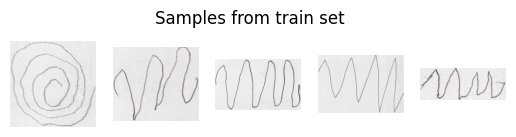

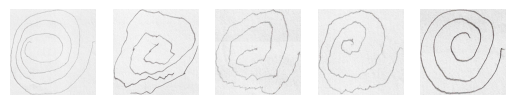

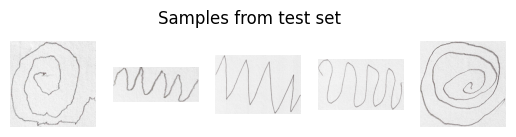

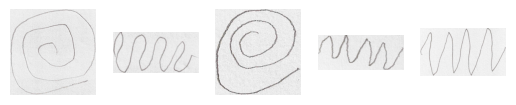

In [14]:
title = "Samples from train set"
plotSamples(X_train, title)
title = "Samples from test set"
plotSamples(X_test, title)

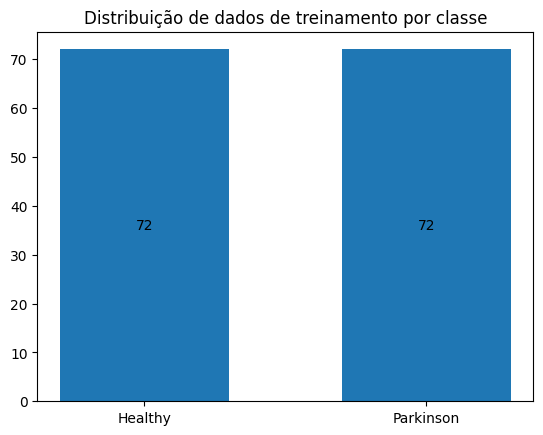

In [15]:
dist = countClasses(y_train, [0,1])
classes = ['Healthy', 'Parkinson']

fig = plt.bar(classes, dist, width=0.6, label=classes)
plt.bar_label(fig, label_type='center')
plt.title('Distribuição de dados de treinamento por classe')

plt.show()

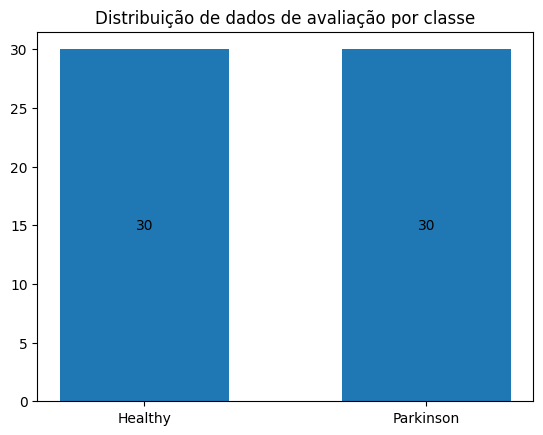

In [16]:
dist = countClasses(y_test, [0,1])
classes = ['Healthy', 'Parkinson']

fig = plt.bar(classes, dist, width=0.6, label=classes)
plt.bar_label(fig, label_type='center')
plt.title('Distribuição de dados de avaliação por classe')

plt.show()

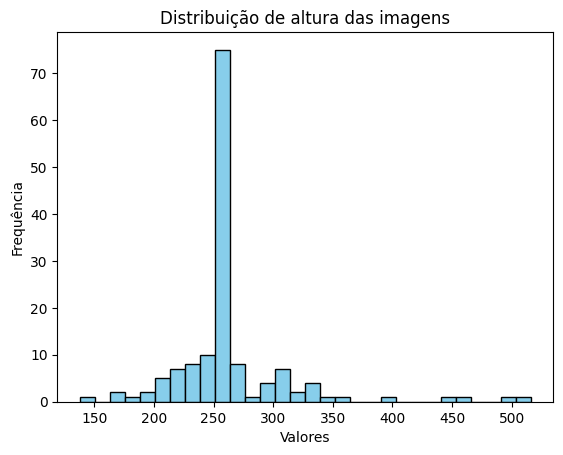

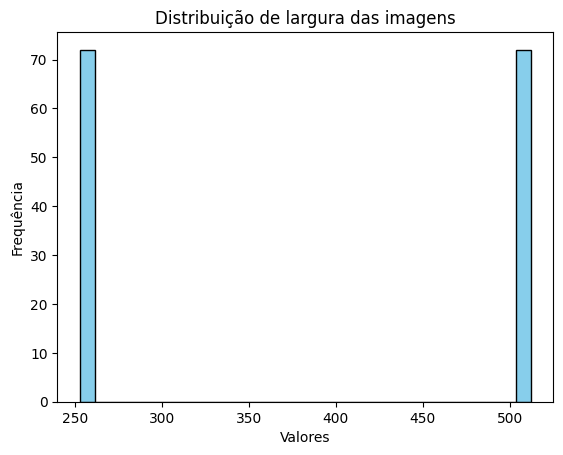

In [17]:
height = [img.shape[0] for img in X_train or X_test]
width = [img.shape[1] for img in X_train or X_test]

unique_height = list(set(height))
unique_width = list(set(width))

dist_height = countClasses(height, unique_height)
dist_width = countClasses(width, unique_width)

plt.hist(height, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Distribuição de altura das imagens')

plt.show()

plt.hist(width, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Distribuição de largura das imagens')

plt.show()

## Data processing

In [15]:
# Resize the images with padding
exp_shape = (256, 256)  # Example expected shape
X_train = resize_with_padding(X_train, exp_shape)
X_test = resize_with_padding(X_test, exp_shape)

# Optionally augment the training data
X_train, y_train = augment(X_train, y_train)

X_train, y_train = shuffle(X_train, y_train, random_state=71)
X_test, y_test = shuffle(X_test, y_test, random_state=71)

# Create the datasets
train_dataset = ImageDataset(X_train, y_train, transform=None)  # Add any PyTorch transforms if needed
test_dataset = ImageDataset(X_test, y_test, transform=None)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

## AED dos dados tratados

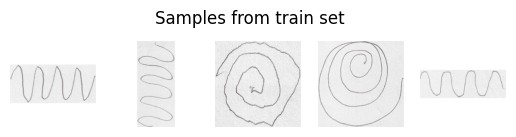

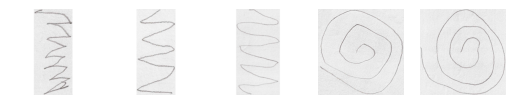

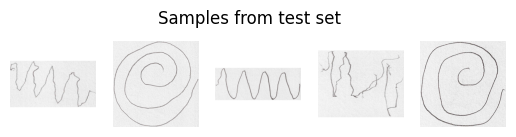

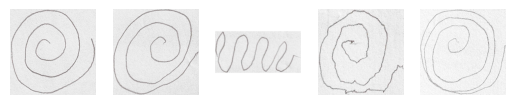

In [19]:
title = "Samples from train set"
plotSamples(X_train, title)
title = "Samples from test set"
plotSamples(X_test, title)

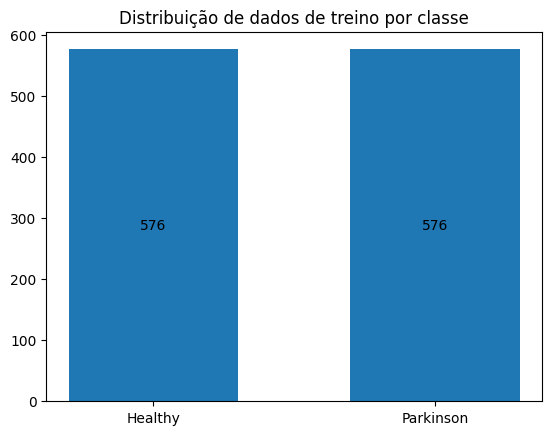

In [20]:
dist = countClasses(y_train, [0,1])
classes = ['Healthy', 'Parkinson']

fig = plt.bar(classes, dist, width=0.6, label=classes)
plt.bar_label(fig, label_type='center')
plt.title('Distribuição de dados de treino por classe')

plt.show()

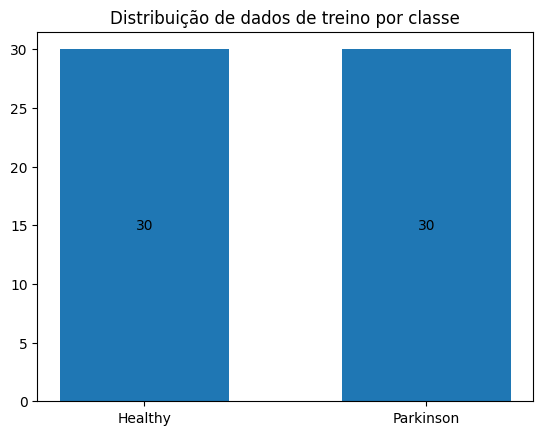

In [21]:
dist = countClasses(y_test, [0,1])
classes = ['Healthy', 'Parkinson']

fig = plt.bar(classes, dist, width=0.6, label=classes)
plt.bar_label(fig, label_type='center')
plt.title('Distribuição de dados de treino por classe')

plt.show()

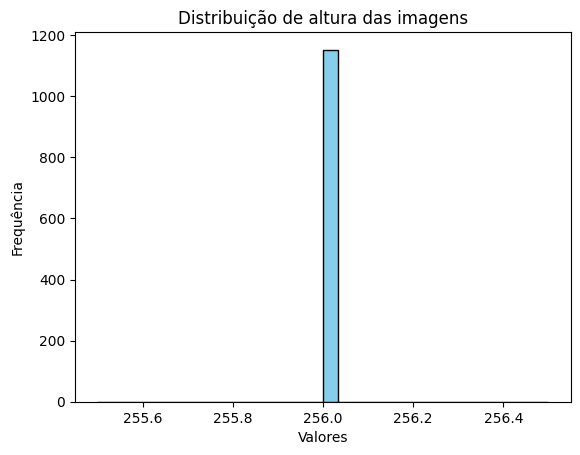

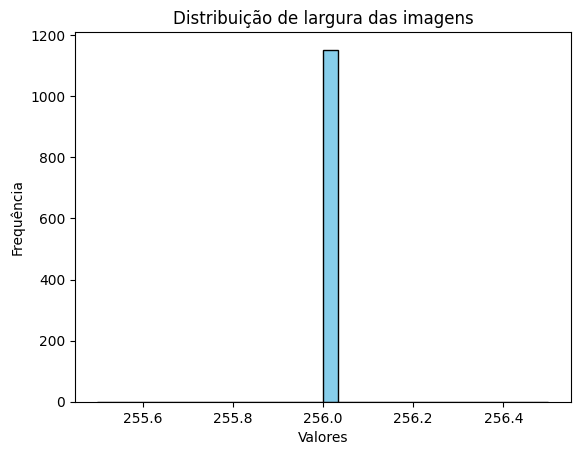

In [22]:
height = [img.shape[0] for img in X_train or X_test]
width = [img.shape[1] for img in X_train or X_test]

unique_height = list(set(height))
unique_width = list(set(width))

dist_height = countClasses(height, unique_height)
dist_width = countClasses(width, unique_width)

plt.hist(height, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Distribuição de altura das imagens')

plt.show()

plt.hist(width, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Distribuição de largura das imagens')

plt.show()

### Data Tensors

In [16]:
# to ndarray to torch tensor

test_data_tensor = torch.tensor(X_test).to(device)
test_labels_tensor = torch.tensor(y_test).to(device)

<ipython-input-16-6e88c074f099>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  test_data_tensor = torch.tensor(X_test).to(device)


## Modelos

### Baixando todos os modelos

In [17]:
%%capture
# DenseNets
densenet121_model = torchvision.models.densenet121(weights = 'DEFAULT')
densenet121_model.to(device)
densenet169_model = torchvision.models.densenet161(weights = 'DEFAULT')
densenet169_model.to(device)

# EffNetsV2
efficientnetv2_S_model = torchvision.models.efficientnet_v2_s(weights = 'DEFAULT')
efficientnetv2_S_model.to(device)
efficientnetv2_M_model = torchvision.models.efficientnet_v2_m(weights = 'DEFAULT')
efficientnetv2_M_model.to(device)

# ResNets
resnet50_model = torchvision.models.resnet50(weights = 'DEFAULT')
resnet50_model.to(device)
resnet101_model = torchvision.models.resnet101(weights = 'DEFAULT')
resnet101_model.to(device)

## Treinamento e avaliação individual

#### DenseNets

##### DenseNet121

In [ ]:
# Avaliando o modelo antes do treinamento
evaluate_model('DenseNet121-base', densenet121_model, test_data_tensor, test_labels_tensor)

[2024-09-03 13:22:26,062] [zeus.device.gpu.nvidia](nvidia.py:46) pynvml is available and initialized.
[2024-09-03 13:22:26,064] [zeus.device.cpu.rapl](rapl.py:129) RAPL is not supported on this CPU.
[2024-09-03 13:22:26,067] [zeus.monitor.energy](energy.py:200) Monitoring GPU indices [0].
[2024-09-03 13:22:26,070] [zeus.monitor.energy](energy.py:201) Monitoring CPU indices []
[2024-09-03 13:22:26,072] [zeus.device.common](common.py:24) Read security capabilities from /proc/self/status -- SYS_ADMIN: True
[2024-09-03 13:22:26,074] [GlobalPowerLimitOptimizer](power_limit.py:290) JIT profiling enabled.
[2024-09-03 13:22:26,076] [GlobalPowerLimitOptimizer](power_limit.py:291) Will wait 1 step(s) before profiling.
[2024-09-03 13:22:26,077] [GlobalPowerLimitOptimizer](power_limit.py:295) Set power limit to the maximum before starting.
[2024-09-03 13:22:26,078] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:22:28,259] [GlobalPowerLimitOptimizer](pow

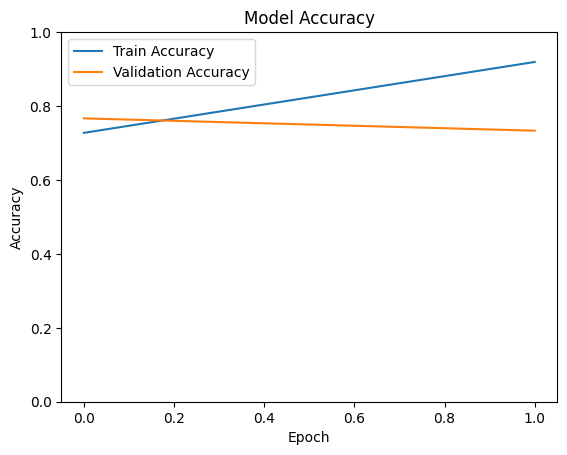

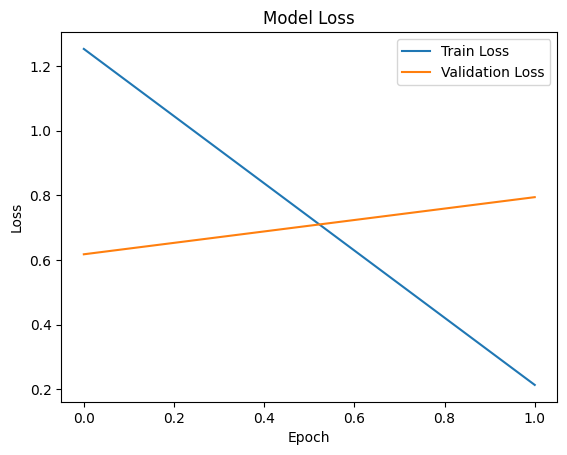

In [18]:
densenet121 = training(densenet121_model, 'DenseNet121', 2, train_loader, test_loader, device)

In [ ]:
evaluate_model('DenseNet121', densenet121_model, test_data_tensor, test_labels_tensor)

##### DenseNet169

In [ ]:
# Avaliando o modelo antes do treinamento
evaluate_model('DenseNet169-base', densenet169_model, test_data_tensor, test_labels_tensor)

[2024-09-03 13:23:16,868] [zeus.monitor.energy](energy.py:200) Monitoring GPU indices [0].
[2024-09-03 13:23:16,871] [zeus.monitor.energy](energy.py:201) Monitoring CPU indices []
[2024-09-03 13:23:16,873] [GlobalPowerLimitOptimizer](power_limit.py:290) JIT profiling enabled.
[2024-09-03 13:23:16,874] [GlobalPowerLimitOptimizer](power_limit.py:291) Will wait 1 step(s) before profiling.
[2024-09-03 13:23:16,876] [GlobalPowerLimitOptimizer](power_limit.py:295) Set power limit to the maximum before starting.
[2024-09-03 13:23:16,877] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:23:17,912] [GlobalPowerLimitOptimizer](power_limit.py:357) Starting warmup for power limit 70 W.
[2024-09-03 13:23:17,917] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:23:25,892] [GlobalPowerLimitOptimizer](power_limit.py:370) Starting actual profiling for power limit 70 W.
[2024-09-03 13:23:46,836] [GlobalPowerLimitOptimi

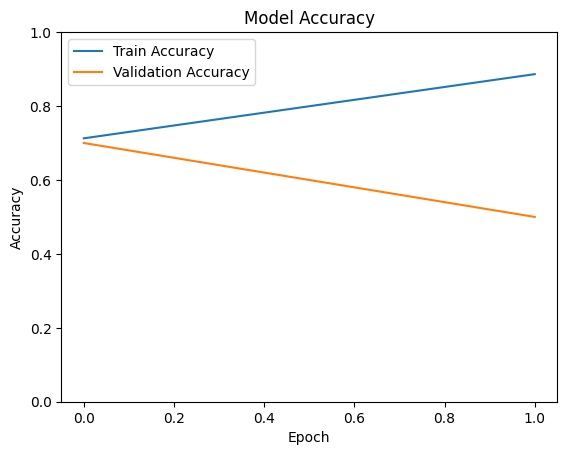

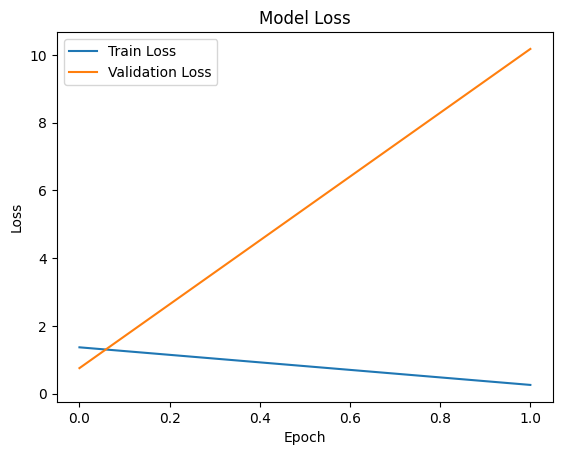

In [21]:
densenet169 = training(densenet169_model, 'DenseNet169', 2, train_loader, test_loader, device)

In [ ]:
evaluate_model('DenseNet169', densenet169, test_data_tensor, test_labels_tensor)

#### ResNets

##### ResNet50

In [ ]:
# Avaliando o modelos antes do treinamento
evaluate_model('ResNet50-base', resnet50_model, test_data_tensor, test_labels_tensor)

[2024-09-03 13:24:37,806] [zeus.monitor.energy](energy.py:200) Monitoring GPU indices [0].
[2024-09-03 13:24:37,807] [zeus.monitor.energy](energy.py:201) Monitoring CPU indices []
[2024-09-03 13:24:37,809] [GlobalPowerLimitOptimizer](power_limit.py:290) JIT profiling enabled.
[2024-09-03 13:24:37,810] [GlobalPowerLimitOptimizer](power_limit.py:291) Will wait 1 step(s) before profiling.
[2024-09-03 13:24:37,811] [GlobalPowerLimitOptimizer](power_limit.py:295) Set power limit to the maximum before starting.
[2024-09-03 13:24:37,813] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:24:38,493] [GlobalPowerLimitOptimizer](power_limit.py:357) Starting warmup for power limit 70 W.
[2024-09-03 13:24:38,497] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:24:42,388] [GlobalPowerLimitOptimizer](power_limit.py:370) Starting actual profiling for power limit 70 W.
[2024-09-03 13:24:52,484] [GlobalPowerLimitOptimi

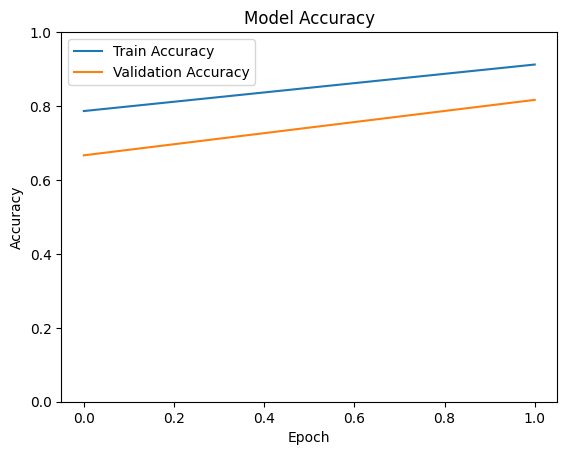

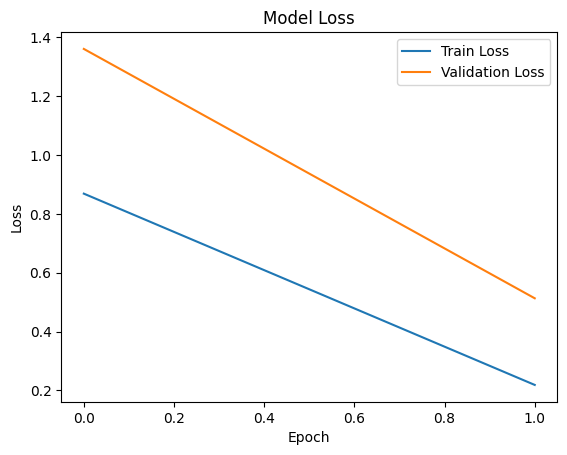

In [22]:
resnet50 = training(resnet50_model, 'ResNet50', 2, train_loader, test_loader, device)

In [ ]:
evaluate_model('ResNet50', resnet50, test_data_tensor, test_labels_tensor)

##### ResNet101

In [ ]:
# avaliando o modelo antes do treinamento
evaluate_model('ResNet101-base', resnet101_model, test_data_tensor, test_labels_tensor)

[2024-09-03 13:27:12,904] [zeus.monitor.energy](energy.py:200) Monitoring GPU indices [0].
[2024-09-03 13:27:12,906] [zeus.monitor.energy](energy.py:201) Monitoring CPU indices []
[2024-09-03 13:27:12,911] [GlobalPowerLimitOptimizer](power_limit.py:290) JIT profiling enabled.
[2024-09-03 13:27:12,912] [GlobalPowerLimitOptimizer](power_limit.py:291) Will wait 1 step(s) before profiling.
[2024-09-03 13:27:12,915] [GlobalPowerLimitOptimizer](power_limit.py:295) Set power limit to the maximum before starting.
[2024-09-03 13:27:12,916] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:27:13,853] [GlobalPowerLimitOptimizer](power_limit.py:357) Starting warmup for power limit 70 W.
[2024-09-03 13:27:13,857] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:27:19,895] [GlobalPowerLimitOptimizer](power_limit.py:370) Starting actual profiling for power limit 70 W.
[2024-09-03 13:27:35,635] [GlobalPowerLimitOptimi

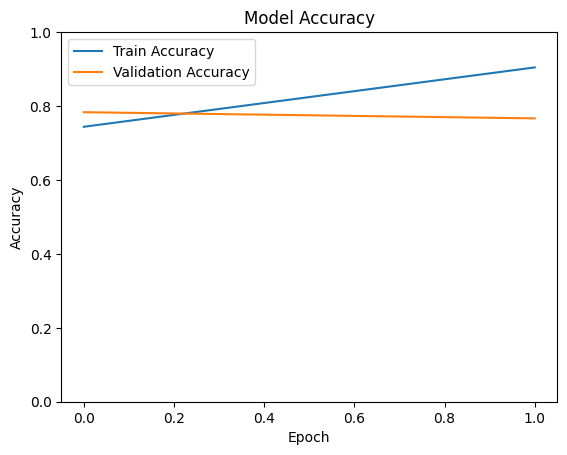

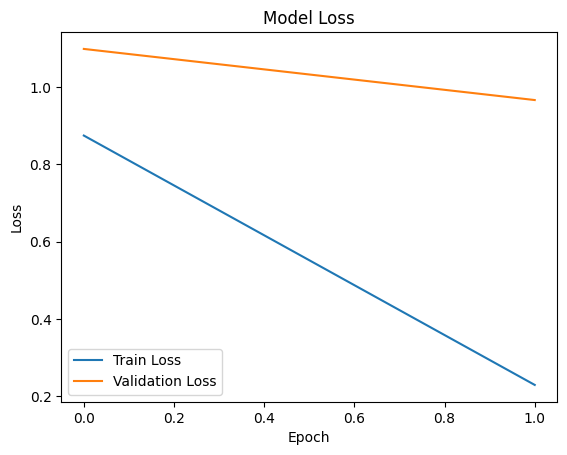

In [25]:
resnet101 = training(resnet101_model, 'ResNet101', 2, train_loader, test_loader, device)

In [ ]:
evaluate_model('ResNet101', resnet101, test_data_tensor, test_labels_tensor)

  #### EfficientNetV2

##### Small


In [ ]:
# avaliando o modelo antes do treinamento
evaluate_model('EfficientNetV2-Small-base', efficientnetv2_S_model, test_data_tensor, test_labels_tensor)

[2024-09-03 13:28:39,370] [zeus.monitor.energy](energy.py:200) Monitoring GPU indices [0].
[2024-09-03 13:28:39,372] [zeus.monitor.energy](energy.py:201) Monitoring CPU indices []
[2024-09-03 13:28:39,374] [GlobalPowerLimitOptimizer](power_limit.py:290) JIT profiling enabled.
[2024-09-03 13:28:39,375] [GlobalPowerLimitOptimizer](power_limit.py:291) Will wait 1 step(s) before profiling.
[2024-09-03 13:28:39,376] [GlobalPowerLimitOptimizer](power_limit.py:295) Set power limit to the maximum before starting.
[2024-09-03 13:28:39,378] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:28:40,209] [GlobalPowerLimitOptimizer](power_limit.py:357) Starting warmup for power limit 70 W.
[2024-09-03 13:28:40,214] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:28:44,432] [GlobalPowerLimitOptimizer](power_limit.py:370) Starting actual profiling for power limit 70 W.
[2024-09-03 13:28:55,566] [GlobalPowerLimitOptimi

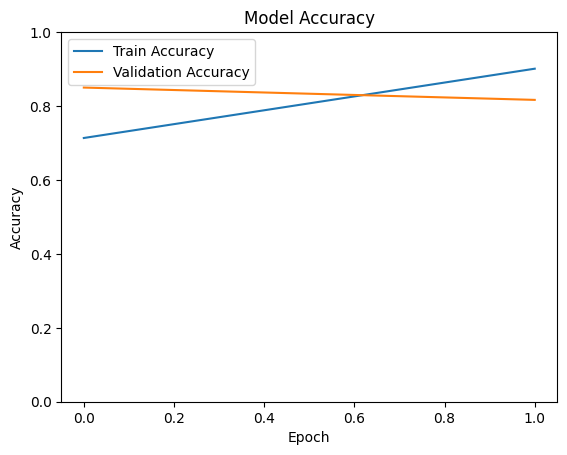

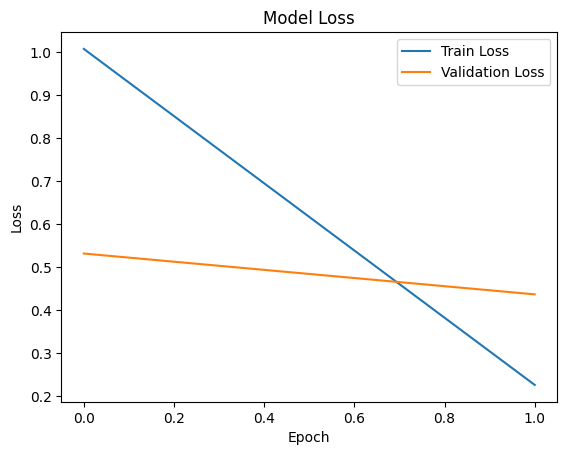

In [27]:
efficientnetv2_S = training(efficientnetv2_S_model, 'EfficientNetV2-Small', 2, train_loader, test_loader, device)

In [ ]:
evaluate_model('EfficientNetV2-Small', efficientnetv2_S, test_data_tensor, test_labels_tensor)

##### Medium


In [ ]:
# avaliando o modelo antes do treinamento
evaluate_model('EfficientNetV2-Medium-base', efficientnetv2_M_model, test_data_tensor, test_labels_tensor)

[2024-09-03 13:29:21,162] [zeus.monitor.energy](energy.py:200) Monitoring GPU indices [0].
[2024-09-03 13:29:21,164] [zeus.monitor.energy](energy.py:201) Monitoring CPU indices []
[2024-09-03 13:29:21,166] [GlobalPowerLimitOptimizer](power_limit.py:290) JIT profiling enabled.
[2024-09-03 13:29:21,167] [GlobalPowerLimitOptimizer](power_limit.py:291) Will wait 1 step(s) before profiling.
[2024-09-03 13:29:21,168] [GlobalPowerLimitOptimizer](power_limit.py:295) Set power limit to the maximum before starting.
[2024-09-03 13:29:21,169] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:29:22,169] [GlobalPowerLimitOptimizer](power_limit.py:357) Starting warmup for power limit 70 W.
[2024-09-03 13:29:22,174] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:29:29,798] [GlobalPowerLimitOptimizer](power_limit.py:370) Starting actual profiling for power limit 70 W.
[2024-09-03 13:29:49,723] [GlobalPowerLimitOptimi

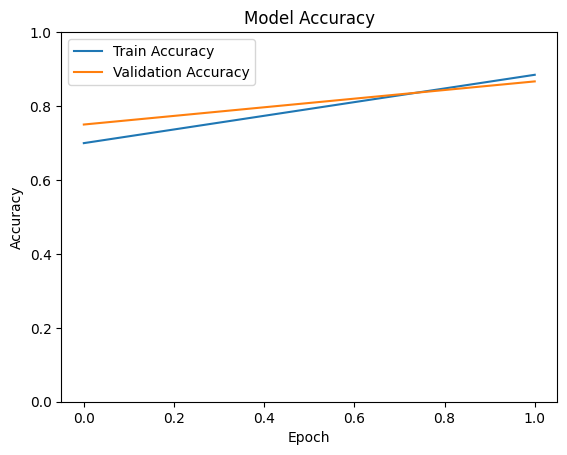

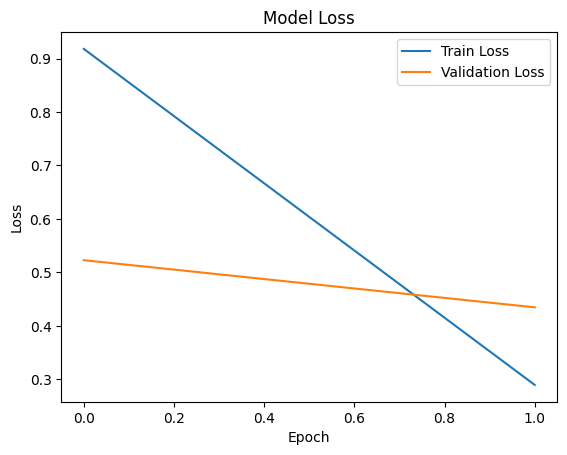

In [29]:
efficientnetv2_M = training(efficientnetv2_M_model, 'EfficientNetV2-Medium', 2, train_loader, test_loader, device)

In [ ]:
evaluate_model('EfficientNetV2-Medium', efficientnetv2_M, test_data_tensor, test_labels_tensor)

## CNN Ensemble


In [32]:
# Assuming the outputs of modelA, modelB, and modelC have 1000 features each
ensemble_model = EnsembleModel(efficientnetv2_S_model, efficientnetv2_M_model, resnet50_model, resnet101_model, densenet121_model, densenet169_model)

# Freeze all layers except the classifier
for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True

ensemble_model = ensemble_model.to(device)

[2024-09-03 13:31:02,061] [zeus.monitor.energy](energy.py:200) Monitoring GPU indices [0].
[2024-09-03 13:31:02,063] [zeus.monitor.energy](energy.py:201) Monitoring CPU indices []
[2024-09-03 13:31:02,065] [GlobalPowerLimitOptimizer](power_limit.py:290) JIT profiling enabled.
[2024-09-03 13:31:02,067] [GlobalPowerLimitOptimizer](power_limit.py:291) Will wait 1 step(s) before profiling.
[2024-09-03 13:31:02,069] [GlobalPowerLimitOptimizer](power_limit.py:295) Set power limit to the maximum before starting.
[2024-09-03 13:31:02,070] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:31:03,429] [GlobalPowerLimitOptimizer](power_limit.py:357) Starting warmup for power limit 70 W.
[2024-09-03 13:31:03,434] [GlobalPowerLimitOptimizer](power_limit.py:433) Setting power limit to 70 W.
[2024-09-03 13:31:14,087] [GlobalPowerLimitOptimizer](power_limit.py:370) Starting actual profiling for power limit 70 W.
[2024-09-03 13:31:43,106] [GlobalPowerLimitOptimi

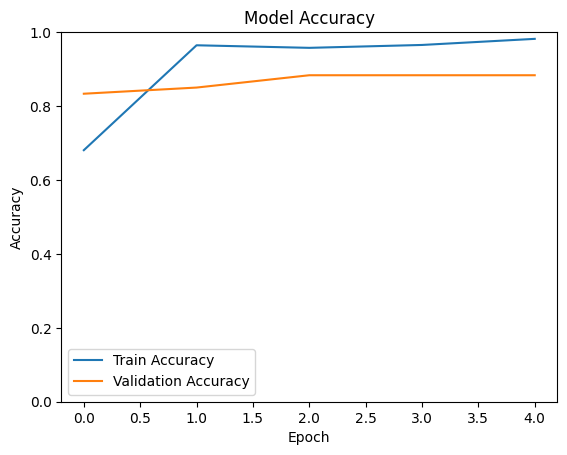

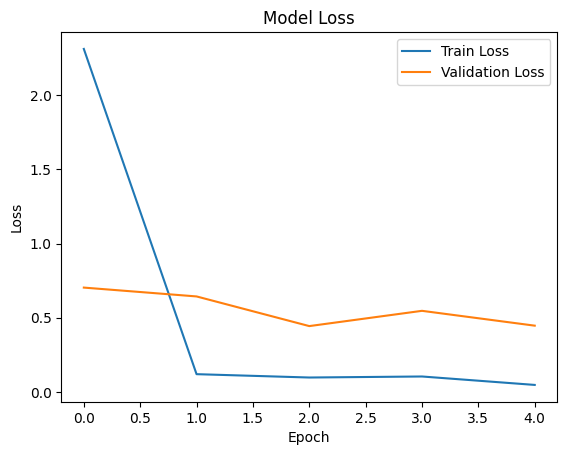

In [33]:
ensemble_training_results = training(ensemble_model,'Ensemble', 5, train_loader, test_loader, device)

## Vision Transformer

In [34]:
class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model # Dimensionality of Model
    self.img_size = img_size # Image Size
    self.patch_size = patch_size # Patch Size
    self.n_channels = n_channels # Number of Channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

  # B: Batch Size
  # C: Image Channels
  # H: Image Height
  # W: Image Width
  # P_col: Patch Column
  # P_row: Patch Row
  def forward(self, x):
    x = self.linear_project(x) # (B, C, H, W) -> (B, d_model, P_col, P_row)

    x = x.flatten(2) # (B, d_model, P_col, P_row) -> (B, d_model, P)

    x = x.transpose(1, 2) # (B, d_model, P) -> (B, P, d_model)

    return x

In [35]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super().__init__()

    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # Classification Token

    # Creating positional encoding
    pe = torch.zeros(max_seq_length, d_model)

    for pos in range(max_seq_length):
      for i in range(d_model):
        if i % 2 == 0:
          pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
        else:
          pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    # Expand to have class token for every image in batch
    tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

    # Adding class tokens to the beginning of each embedding
    x = torch.cat((tokens_batch,x), dim=1)

    # Add positional encoding to embeddings
    x = x + self.pe

    return x

In [36]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(d_model, head_size)
    self.key = nn.Linear(d_model, head_size)
    self.value = nn.Linear(d_model, head_size)

  def forward(self, x):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1)

    # Scaling
    attention = attention / (self.head_size ** 0.5)

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

In [37]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.head_size = d_model // n_heads

    self.W_o = nn.Linear(d_model, d_model)

    self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

  def forward(self, x):
    # Combine attention heads
    out = torch.cat([head(x) for head in self.heads], dim=-1)

    out = self.W_o(out)

    return out

In [38]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    # Sub-Layer 1 Normalization
    self.ln1 = nn.LayerNorm(d_model)

    # Multi-Head Attention
    self.mha = MultiHeadAttention(d_model, n_heads)

    # Sub-Layer 2 Normalization
    self.ln2 = nn.LayerNorm(d_model)

    # Multilayer Perception
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    # Residual Connection After Sub-Layer 1
    out = x + self.mha(self.ln1(x))

    # Residual Connection After Sub-Layer 2
    out = out + self.mlp(self.ln2(out))

    return out

In [39]:
class VisionTransformer(nn.Module):
  def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()

    assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_model = d_model # Dimensionality of model
    self.n_classes = n_classes # Number of classes
    self.img_size = img_size # Image size
    self.patch_size = patch_size # Patch size
    self.n_channels = n_channels # Number of channels
    self.n_heads = n_heads # Number of attention heads

    self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
    self.max_seq_length = self.n_patches + 1

    self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
    self.positional_encoding = PositionalEncoding( self.d_model, self.max_seq_length)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder( self.d_model, self.n_heads) for _ in range(n_layers)])

    # Classification MLP
    self.classifier = nn.Sequential(
        nn.Linear(self.d_model, self.n_classes),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
    x = self.patch_embedding(images)

    x = self.positional_encoding(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:,0])

    return x

### Variáveis de treinamento

In [44]:
d_model = 10
n_classes = 2
img_size = (256,256)
patch_size = (128,128)
n_channels = 3
n_heads = 5
n_layers = 7
batch_size = 64
epochs = 10
alpha = 0.001

### Esquentando GPU

In [45]:
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):

  training_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = transformer(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    training_loss += loss.item()

  print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')

Epoch 1/10 loss: 0.697
Epoch 2/10 loss: 0.695
Epoch 3/10 loss: 0.697
Epoch 4/10 loss: 0.704
Epoch 5/10 loss: 0.692
Epoch 6/10 loss: 0.698
Epoch 7/10 loss: 0.694
Epoch 8/10 loss: 0.697
Epoch 9/10 loss: 0.696
Epoch 10/10 loss: 0.695


### Avaliando o ViT


In [46]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = transformer(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f'\nModel Accuracy: {100 * correct // total} %')



Model Accuracy: 50 %
